# Parse xmls of points of interest


Created by: Orsi Vasarhelyi

Last updated: 03.07.2017.

Parse xml fle s given by the partner and export it to a csv

In [1]:
import pandas as pd
import numpy as np 
from collections import Counter, defaultdict

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# parsing
import os
import sys
import unicodedata
import string
from collections import defaultdict
from bs4 import BeautifulSoup
import json

import sys
sys.path.append("..")
from connect_db import db_connection

In [5]:
# read data

path='/mnt/data/shared/asset_geolocalizzati/'
files=os.listdir(path)

In [6]:
def create_dict(i):
    helper_dict={}
    if len(i.find_all("arr"))>0:
        try:
            helper_dict=json.loads(i.find_all("arr")[0].get_text().strip().strip('"'))
            return helper_dict
        except:
            for el in i.find_all("arr")[0].get_text().strip().split(','):
                texts=el.strip('"').replace('{','').replace('}','').lstrip().split(":")
                helper_dict[texts[0].strip('\'')]=texts[1].strip('\'')
                return helper_dict

In [7]:
parsed_data=defaultdict(dict)
j=0
for t in files:
    with open(path+t) as f:
        print(t, j)
        soup = BeautifulSoup(f, "html.parser")
        docs=soup.findAll('doc')
        print(len(docs))
        for i in docs[1:]:
            j+=1
            results=defaultdict(dict)
            try:
                info_dict=json.loads(i.find_all("arr")[0].get_text().strip().replace('\n',''))
                if type(info_dict)==dict and len(info_dict.keys())>0:
                    results['adress']=info_dict.get('address')
                    results["lat"]=info_dict.get('lat')
                    results["lng"]=info_dict.get('lng')
                    if 'titolo_en' in str(i): 
                        results["eng_name"]=i.select("arr[name=titolo_en]")[0].get_text().strip()
                    else:
                        results['eng_name']='NAN'
                    if 'titolo_it' in str(i):
                        results["it_name"]=i.select("arr[name=titolo_it]")[0].get_text().strip()
                    else:
                        results['it_name']='NAN'
                    results['type']=t.split(".")[0]
                    #print(j)
                    parsed_data[j]=results
            except:
                info_dict=create_dict(i) 
                if len(info_dict.keys())>0:
                    results['adress']=info_dict.get('address')
                    results["lat"]=info_dict.get('lat')
                    results["lng"]=info_dict.get('lng')
                    if 'titolo_en' in str(i): 
                        results["eng_name"]=i.select("arr[name=titolo_en]")[0].get_text().strip()
                    else:
                        results['eng_name']='NAN'
                    if 'titolo_it' in str(i):
                        results["it_name"]=i.select("arr[name=titolo_it]")[0].get_text().strip()
                    else:
                        results['it_name']='NAN'
                    results['type']=t.split(".")[0]
                    #print(j)
                    parsed_data[j]=results
                

attrazioni.xml 0
794
eventi.xml 793
226
idee.xml 1018
409
itinerari.xml 1426
193
localita.xml 1618
297
offerte.xml 1914
61
propostediviaggio.xml 1974
67
ricette.xml 2040
21
sapori.xml 2060
22


In [8]:
df=pd.DataFrame.from_dict(parsed_data)

In [9]:
df.T['type'].value_counts().sort_values()

ricette               20
sapori                21
offerte               60
propostediviaggio     66
itinerari            192
eventi               219
localita             296
idee                 408
attrazioni           793
Name: type, dtype: int64

In [77]:
df.T.to_csv("/mnt/data/shared/points_of_interest.csv")

In [10]:
df=df.T

In [11]:
df.head()

,adress,eng_name,it_name,lat,lng,type
1,,The Bruno Carmagnini Museum of Rural Society,Museo della civiltà contadina Bruno Carmagnini...,43.8336,11.2187,attrazioni
2,"Unnamed Road, 56030 Lajatico PI, Italy",The Fort of Pietracassia,La Rocca di Pietracassia,43.4306,10.6832,attrazioni
3,"Via Apuana, 5BIS, 54033 Carrara MS, Italy",The Sanctuary ‘delle Grazie’,Il Santuario delle Grazie,44.0805,10.0954,attrazioni
4,"Capraia Isola, 57032 Capraia isola LI, Italia",NAN,"Isola di Capraia: tra calette, grotte e sabbia...",43.0378,9.81807,attrazioni
5,"Via Carlo Ciampi, 2, 50019 Sesto Fiorentino FI...",Villa Villoresi and the treasures of Colonnata,Villa Villoresi e i gioielli di Colonnata,43.8407,11.2063,attrazioni


# Create visualizations on a map

In [12]:
import geopandas as gpd

In [13]:
df2=df.dropna(subset=['lng', 'lat'])

In [14]:
from shapely.geometry import Point

df2['geometry'] = df2.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
D=gpd.GeoDataFrame(df2)

In [16]:
D.head()

,adress,eng_name,it_name,lat,lng,type,geometry
1,,The Bruno Carmagnini Museum of Rural Society,Museo della civiltà contadina Bruno Carmagnini...,43.8336,11.2187,attrazioni,POINT (11.218748 43.833555)
2,"Unnamed Road, 56030 Lajatico PI, Italy",The Fort of Pietracassia,La Rocca di Pietracassia,43.4306,10.6832,attrazioni,POINT (10.68319589999999 43.43064649999999)
3,"Via Apuana, 5BIS, 54033 Carrara MS, Italy",The Sanctuary ‘delle Grazie’,Il Santuario delle Grazie,44.0805,10.0954,attrazioni,POINT (10.095396 44.080474)
4,"Capraia Isola, 57032 Capraia isola LI, Italia",NAN,"Isola di Capraia: tra calette, grotte e sabbia...",43.0378,9.81807,attrazioni,POINT (9.818073199999958 43.0377826)
5,"Via Carlo Ciampi, 2, 50019 Sesto Fiorentino FI...",Villa Villoresi and the treasures of Colonnata,Villa Villoresi e i gioielli di Colonnata,43.8407,11.2063,attrazioni,POINT (11.206276 43.84069)


In [18]:
# Read in maps

# Load maps data 
crs= {'init' :'epsg:4326'}

# load data from TPT
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"
new_reg =  r"/mnt/data/shared/ITA_shapefiles/Tus_28districts.shp"

# important cities 
important_cities_file = r"/mnt/data/shared/important_cities.csv"


df_reg = gpd.read_file(regions)
df_pro = gpd.read_file(provinces)
df_mun = gpd.read_file(municipalities)
df_newreg = gpd.read_file(new_reg)
important_cities = pd.read_csv(important_cities_file)

df_reg_tusc = df_reg[df_reg["COD_REG"] == 9] # tuscany
df_pro_tusc = df_pro[df_pro["COD_REG"] == 9]
df_mun_tusc = df_mun[df_mun["COD_REG"] == 9]

# Convert coordinates in WGS84 to Lat Lon format (DO NOT use for the _github files)
# see http://geopandas.org/projections.html
df_reg_tusc['geometry'] = df_reg_tusc['geometry'].to_crs(epsg=4326)
df_pro_tusc['geometry'] = df_pro_tusc['geometry'].to_crs(epsg=4326)
df_mun_tusc['geometry'] = df_mun_tusc['geometry'].to_crs(epsg=4326)

df_mun_tusc.crs = crs
df_reg_tusc.crs = crs
df_pro_tusc.crs = crs


/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [20]:
D=D.drop([309, 309, 921, 894, 266])

In [22]:
D.crs =  crs

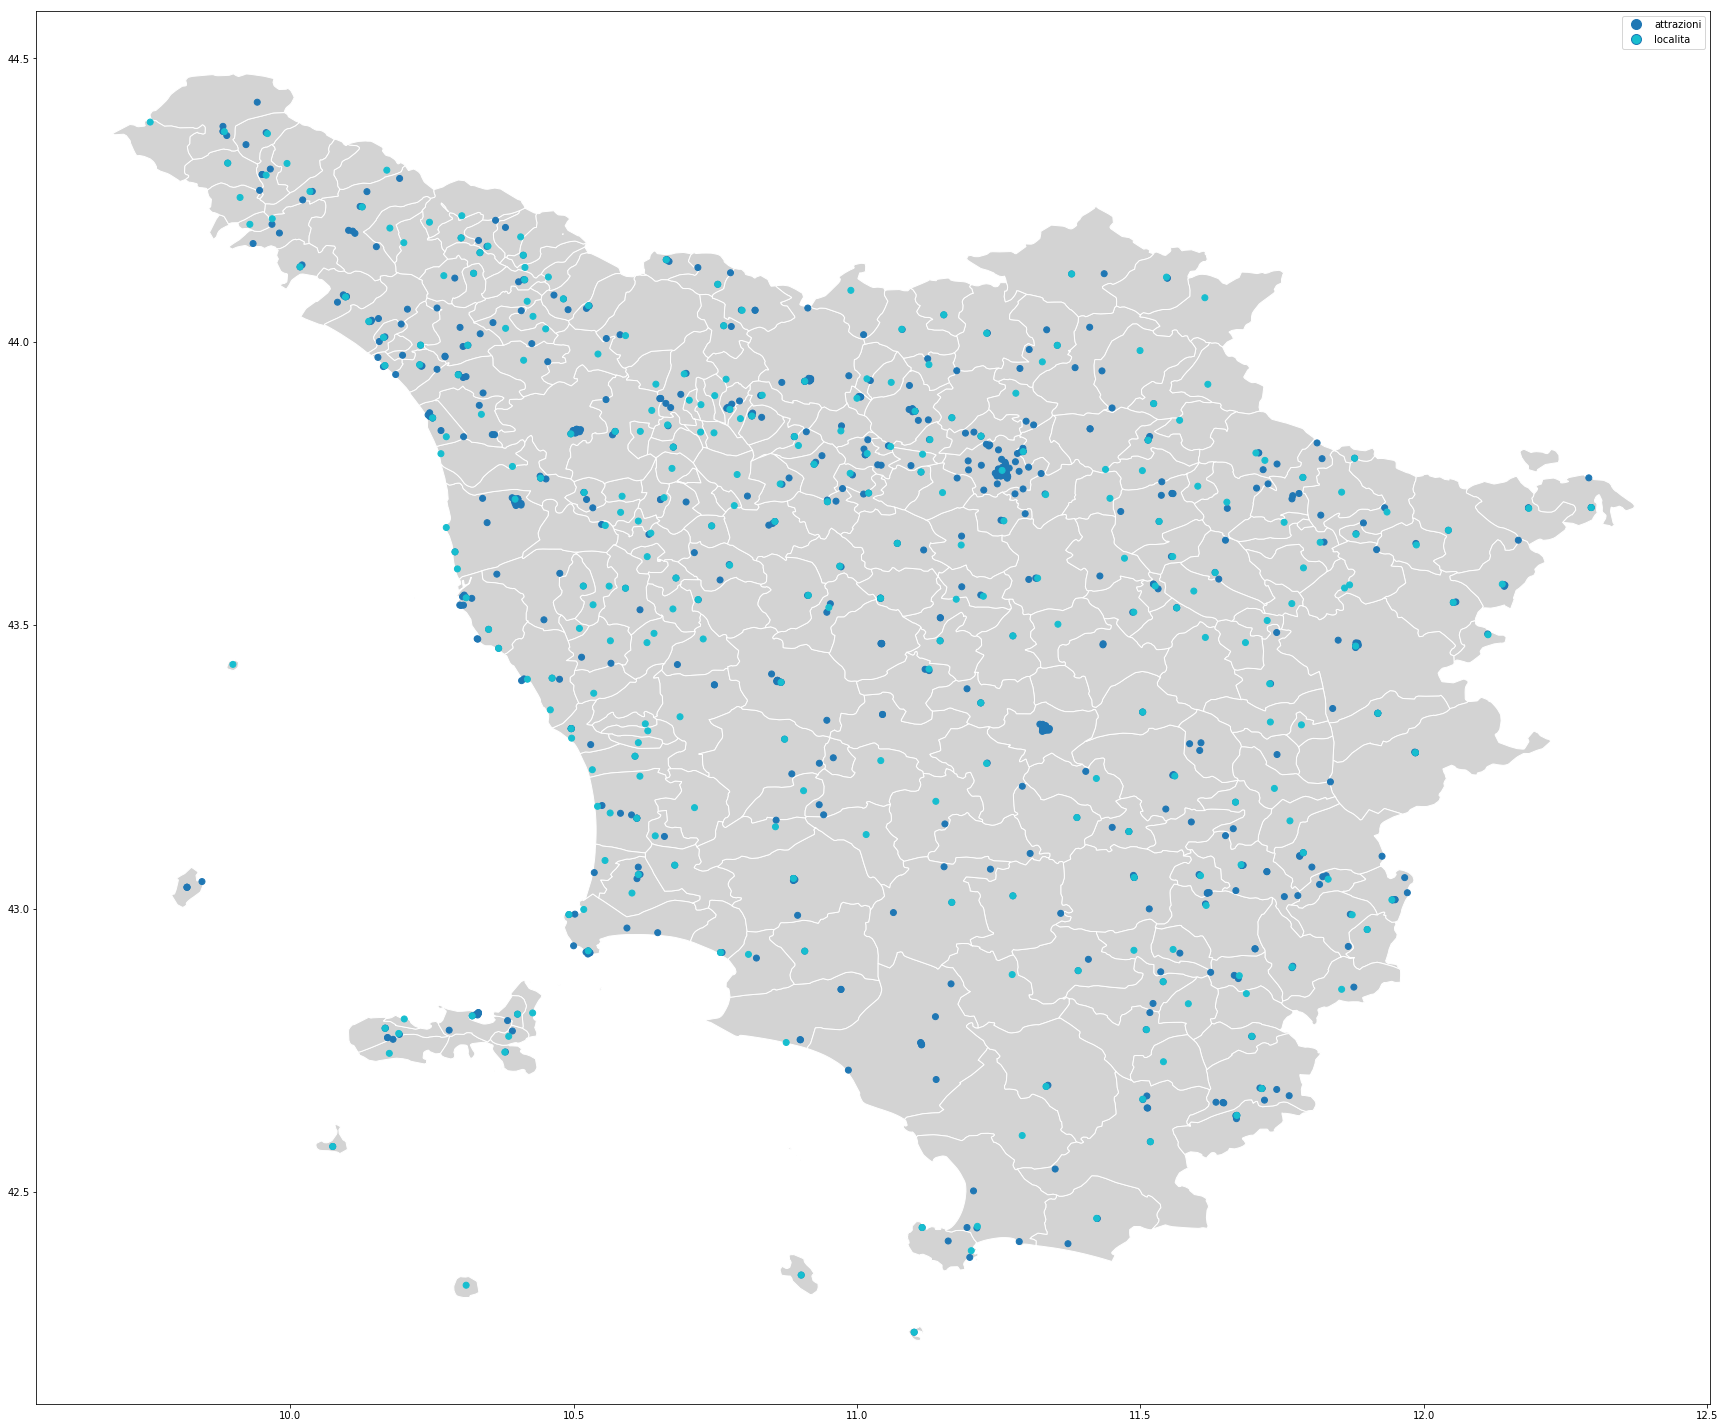

In [23]:
ax=df_mun_tusc.plot(figsize=(30, 30), edgecolor='white', color='lightgrey')
D[(D['type']=='attrazioni')| (D['type']=='localita')].plot(ax=ax, column='type', legend= True)

In [35]:
len(df)

2075

In [34]:
df.type.value_counts()

attrazioni           793
idee                 408
localita             296
eventi               219
itinerari            192
propostediviaggio     66
offerte               60
sapori                21
ricette               20
Name: type, dtype: int64